# Imports

In [1]:
import sys, os

from math import log10
from numpy import array, pi

import pandas as pd
import numpy as np
from numpy import concatenate
from bisect import bisect_left
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
%matplotlib inline
from hist import Hist
import hist

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import zero_one_loss, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.base import clone
# algorithms:
from sklearn.tree import export_graphviz, DecisionTreeClassifier#, plot_tree, export_text # Available in later versions
#import graphviz

# Setup plotting

In [2]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'family' : 'serif','weight' : 'normal','size'   : 22}
plt.rc('font', **font)

SE_size = 47.07

# Parameters

# Get data

In [3]:
df1 = pd.read_csv('tritium_ML_data.csv')
df2 = pd.read_csv('bg_sr1_vetoes.csv')
df3 = pd.read_csv('bg_sr1_vetoes_gassplit.csv')

df = pd.concat([df1,df3], ignore_index=True)
df = df.drop('Unnamed: 0', axis = 1)
df.head()


,runID,eventID,area,max_pulse_height,ext_elec,x,y,r,S2_width,label,type,dt10_05,dt25_10,dt50_25,dt75_50,dt90_75,dt95_90
0,8155,22203,6436.112305,2.266133,136.734912,-45.228909,-22.735205,50.621573,6930.0,2,tritium,320.0,570.0,680.0,780.0,740.0,380.0
1,8155,22291,5628.426270,2.136970,119.575659,10.828576,30.402670,32.273525,7150.0,2,tritium,360.0,770.0,850.0,740.0,690.0,430.0
2,8155,22426,9805.306641,4.920897,208.313292,6.381312,32.306606,32.930806,7000.0,2,tritium,270.0,480.0,580.0,570.0,510.0,300.0
3,8170,57019,6517.310059,2.850476,138.459955,-24.567440,4.934042,25.058010,5800.0,2,tritium,270.0,550.0,640.0,620.0,580.0,400.0
4,8144,57701,18532.921875,5.245479,393.731079,32.857990,30.225632,44.645675,8690.0,2,tritium,440.0,770.0,930.0,790.0,620.0,330.0


# Re-weight data

In [4]:
electron_axis = hist.axis.Regular(100,5,500,name="electrons",
                           label="Extracted electrons",flow=False)

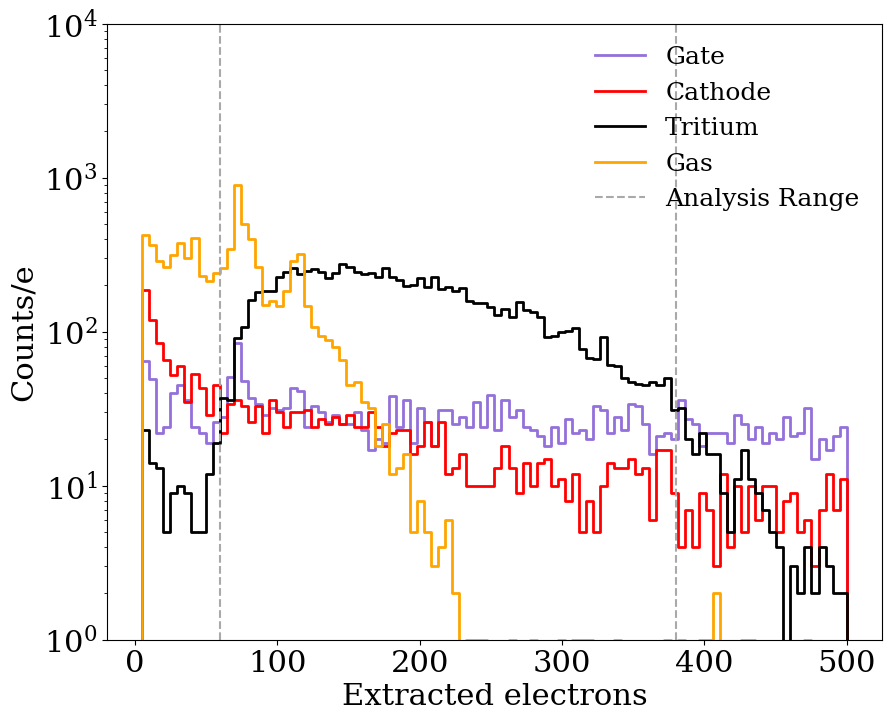

In [5]:
gate_hist = Hist(electron_axis)
gate_cut = df.type == "gate"
gate_hist.fill(df.ext_elec[gate_cut])

gas_hist = Hist(electron_axis)
gas_cut = df.type == "gas"
gas_hist.fill(df.ext_elec[gas_cut])

cath_hist = Hist(electron_axis)
cath_cut = df.type == "cathode"
cath_hist.fill(df.ext_elec[cath_cut])

trit_hist = Hist(electron_axis)
trit_cut = df.type == "tritium"
trit_hist.fill(df.ext_elec[trit_cut])

fig, ax = plt.subplots(figsize=(10, 8))
gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
gas_hist.plot(color='orange',ls='-',lw=2,yerr=False,label='Gas',ax=ax)


plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[1,10000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [6]:
# implementing thresholds
thresh_cut = (60 < df.ext_elec) & (df.ext_elec < 380)
df_cut_gas = df[thresh_cut].reset_index().drop('index', axis = 1)

In [7]:
# handscanning the weird cathode data bumps 
S2_gate_cut = (100 < df.ext_elec) & (df.ext_elec < 140) 
for ii in range(1,11):
    print('%s\t%s'%(df.runID[S2_gate_cut&gate_cut].to_numpy()[ii], df.eventID[S2_gate_cut&gate_cut].to_numpy()[ii]))
    


6975	17189
6993	33265
6986	30110
7051	83963
7022	141385
6988	3398
7047	3839
7058	18772
7016	50349
6967	66574


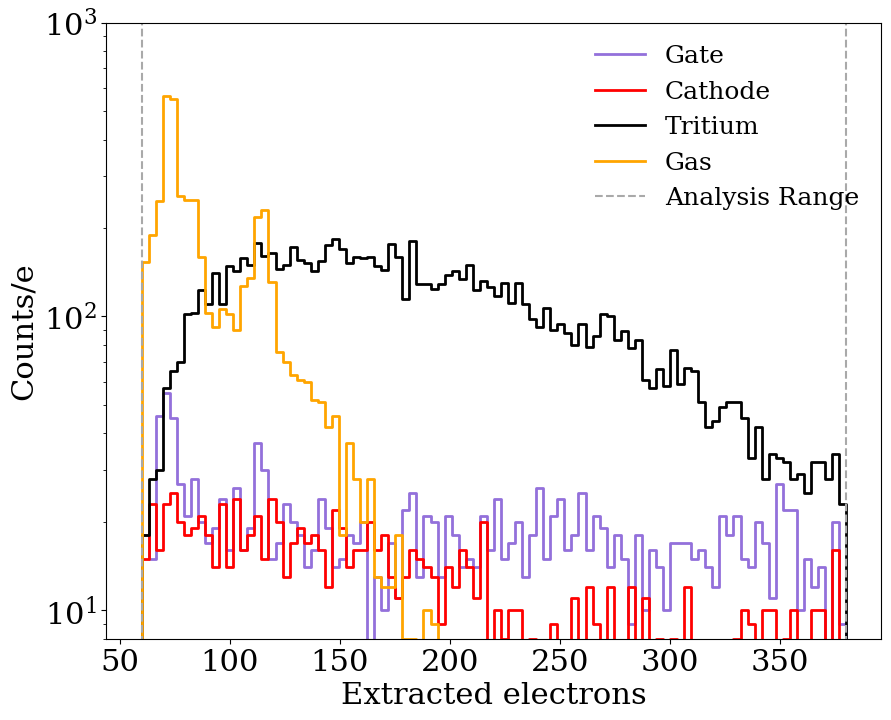

In [8]:
# histogram with threshold data
electron_axis2 = hist.axis.Regular(100,60,380,name="electrons", label="Extracted electrons",flow=False)

gate_hist2 = Hist(electron_axis2)
gate_cut2 = df_cut_gas.type == "gate"
gate_hist2.fill(df_cut_gas.ext_elec[gate_cut2])

cath_hist2 = Hist(electron_axis2)
cath_cut2 = df_cut_gas.type == "cathode"
cath_hist2.fill(df_cut_gas.ext_elec[cath_cut2])

trit_hist2 = Hist(electron_axis2)
trit_cut2 = df_cut_gas.type == "tritium"
trit_hist2.fill(df_cut_gas.ext_elec[trit_cut2])

gas_hist2 = Hist(electron_axis2)
gas_cut2 = df_cut_gas.type == "gas"
gas_hist2.fill(df_cut_gas.ext_elec[gas_cut2])


fig, ax = plt.subplots(figsize=(10, 8))
gate_hist2.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist2.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist2.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
gas_hist2.plot(color='orange',ls='-',lw=2,yerr=False,label='Gas',ax=ax)


plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[8,1000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [9]:
#weighting data w/o gas events 
weight_list = []

for ii in range(df_cut_gas.shape[0]):
    if df_cut_gas.type[ii] == 'gate':
        index = np.searchsorted(gate_hist2.to_numpy()[1],df_cut_gas.ext_elec[ii]) - 1
        bin_counts = gate_hist2[index]
    elif df_cut_gas.type[ii] == 'cathode':
        index = np.searchsorted(cath_hist2.to_numpy()[1],df_cut_gas.ext_elec[ii]) - 1
        bin_counts = cath_hist2[index]
    elif df_cut_gas.type[ii] == 'tritium':
        index = np.searchsorted(trit_hist2.to_numpy()[1],df_cut_gas.ext_elec[ii]) - 1
        bin_counts = trit_hist2[index]     
    weight_list.append(1/bin_counts)
        
df_cut_gas['weights_no_gas'] = weight_list

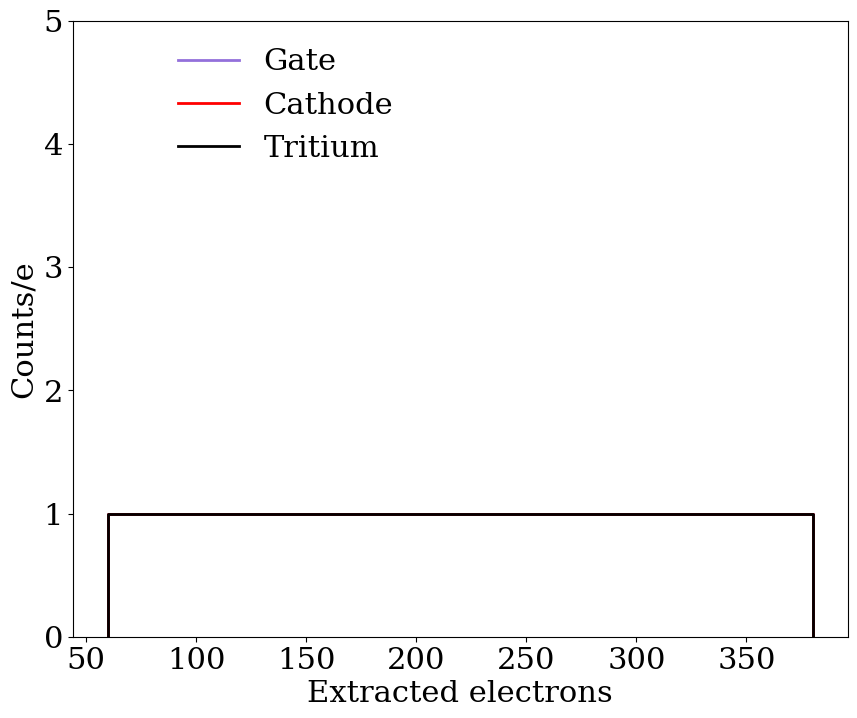

In [10]:
norm_gate_hist = Hist(electron_axis2)
norm_gate_hist.fill(df_cut_gas.ext_elec[gate_cut2],weight = df_cut_gas.weights_no_gas[gate_cut2])

norm_cath_hist = Hist(electron_axis2)
norm_cath_hist.fill(df_cut_gas.ext_elec[cath_cut2],weight = df_cut_gas.weights_no_gas[cath_cut2])

norm_trit_hist = Hist(electron_axis2)
norm_trit_hist.fill(df_cut_gas.ext_elec[trit_cut2],weight = df_cut_gas.weights_no_gas[trit_cut2])

fig, ax = plt.subplots(figsize=(10, 8))
norm_gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
norm_cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
norm_trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)

ax.set(xlabel='Extracted electrons',ylabel='Counts/e',ylim=[0,5])
ax.legend(bbox_to_anchor=(0.1,1),loc='upper left',frameon=False)

plt.show()

# Machine learning

### Prepare data for machine learning

In [11]:
df_cut_gas.loc[df_cut_gas["type"] == "tritium", "label"] = 1
df_cut_gas.loc[df_cut_gas["type"] == "gate", "label"] = 0
df_cut = df_cut_gas[df_cut_gas["type"] != 'gas'] #removing gas events


In [12]:
df_gate = df_cut[df_cut["type"] != 'gate']
features = ['max_pulse_height',
       'dt10_05', 'dt25_10', 'dt50_25', 'dt75_50', 'dt90_75', 'dt95_90',
       'ext_elec']

X = df_cut[features]
Y = df_cut['label']
T = df_cut['type']
W = df_cut['weights_no_gas'] # - should this be the weight calculated above? 
A = df_cut['area']
R = df_cut['r']
X_raw = df_cut['x']
Y_raw = df_cut['y']
eventID = df_cut['eventID']
runID = df_cut['runID']
width = df_cut['S2_width']
X_train_unscaled, X_test_unscaled, \
Y_train, Y_test, \
A_train, A_test, \
T_train, T_test, \
W_train, W_test, \
R_train, R_test, \
X_raw_train, X_raw_test, \
Y_raw_train, Y_raw_test,  \
eventID_train, eventID_test, \
runID_train, runID_test,  \
width_train, width_test = \
train_test_split(X, Y, A, T, W, R, X_raw, Y_raw, eventID, runID, width, random_state=0)

In [13]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled.astype('float64'))
X_test = scaler.transform(X_test_unscaled.astype('float64'))
E_test = A_test/SE_size

### Adaptively boosted decision tree

In [14]:
DTC = DecisionTreeClassifier(max_depth=1,min_samples_split=2)
ABC = AdaBoostClassifier(base_estimator=DTC,n_estimators=100,algorithm = 'SAMME')
model = ABC.fit(X_train, Y_train.values.ravel()
                ,sample_weight=W_train.values.ravel().astype('float64'))

Y_score = model.decision_function(X_test)

model.score(X_train, Y_train, sample_weight=W_train.astype('float64')), \
model.score(X_test, Y_test, sample_weight=W_test.astype('float64')) 

C:\Users\lizzi\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


(0.884874248104353, 0.8839847185074619)

# Understanding machine learning

In [15]:
bin_labels = ['Total', r'60 < $n_e$ < 100', r'100 < $n_e$ < 140', r'140 < $n_e$ < 180', r'180 < $n_e$ < 220',
              r'220 < $n_e$ < 240', r'240 < $n_e$ < 280', r'280 < $n_e$ < 320', r'320 < $n_e$ < 380']
bin_colors = ["black", "purple", "darkblue", "cyan", "green", "gold", "orange", "red", "hotpink"  ]

In [16]:
test_error_list = []
start = 60
tritium_cut = T_test == 'tritium'
for i in range(8):
    test_error = [ ]
    bin_cut = (start < E_test) & (E_test < start + 40)
    start += 40
    for test_predict in model.staged_predict(X_test[bin_cut & tritium_cut]):
        test_error.append(1.-accuracy_score(test_predict,Y_test[bin_cut & tritium_cut],sample_weight=W_test[bin_cut & tritium_cut].ravel().astype('float64')))
    test_error_list.append(test_error)

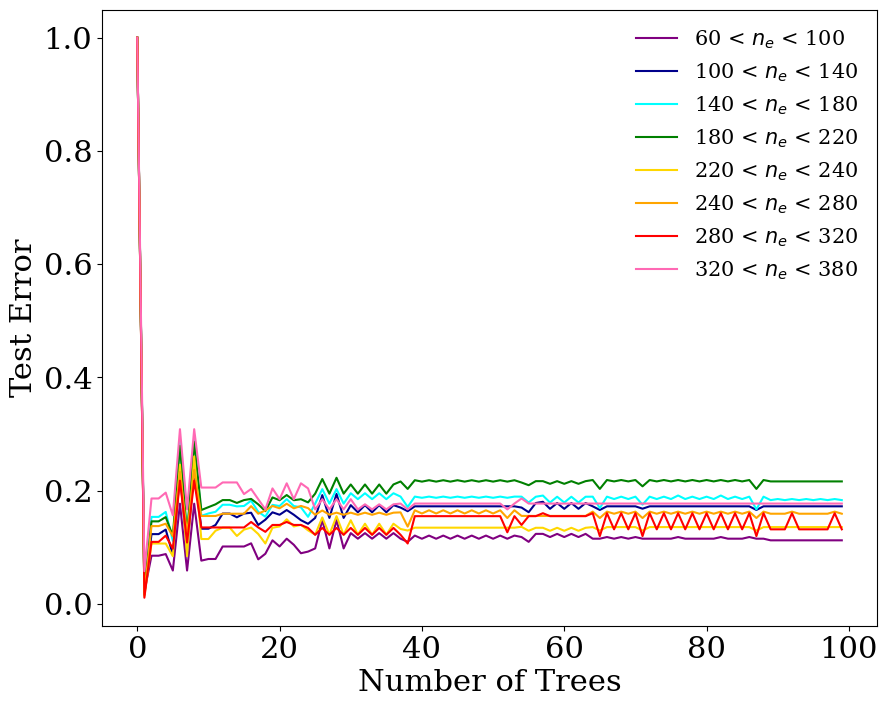

In [17]:
#test error - these are very weird 
for i in range(8):
    #ax.legend(fontsize = 12)
    plt.xlabel('Number of Trees')
    plt.ylabel('Test Error')
    plt.plot(test_error_list[i], color = bin_colors[i+1], label=bin_labels[i+1])
plt.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 15)
    #plt.show()

# Results

In [18]:
FPR_T, TPR_T, TH_T = roc_curve(Y_test,Y_score,sample_weight = W_test, pos_label = 1)

# Bins for ROC curves 

- Full range (60-380)
- For now will do evenly spaced bins i.e:
60-100
100-140
140-180
180-220
220-260
260-300
300-340
340-380


In [19]:
ROC_params_list = [[FPR_T, TPR_T, TH_T]]
Y_score = model.decision_function(X_test)
start = 60
for i in range(8): 
    bin_cut = (start < E_test) & (E_test < start + 40)
    start += 40
    FPR, TPR, TH = roc_curve(Y_test[bin_cut],Y_score[bin_cut],sample_weight = W_test[bin_cut], pos_label = 1)
    ROC_params_list.append([FPR, TPR, TH])
   

In [20]:
# Finding max efficiency ratio 
def eff_calc(e_s, e_b):
        return np.divide(e_s, np.sqrt(e_b), out=np.zeros_like(e_s), where=e_b!=0)
maxes = []
ratios_list = []
for i in range(9):
    ratios = eff_calc(ROC_params_list[i][1], ROC_params_list[i][0])
    ratios_list.append(ratios)
    ind = np.where(ratios == np.max(ratios))
    maxes.append([ROC_params_list[i][1][ind], ROC_params_list[i][0][ind]])

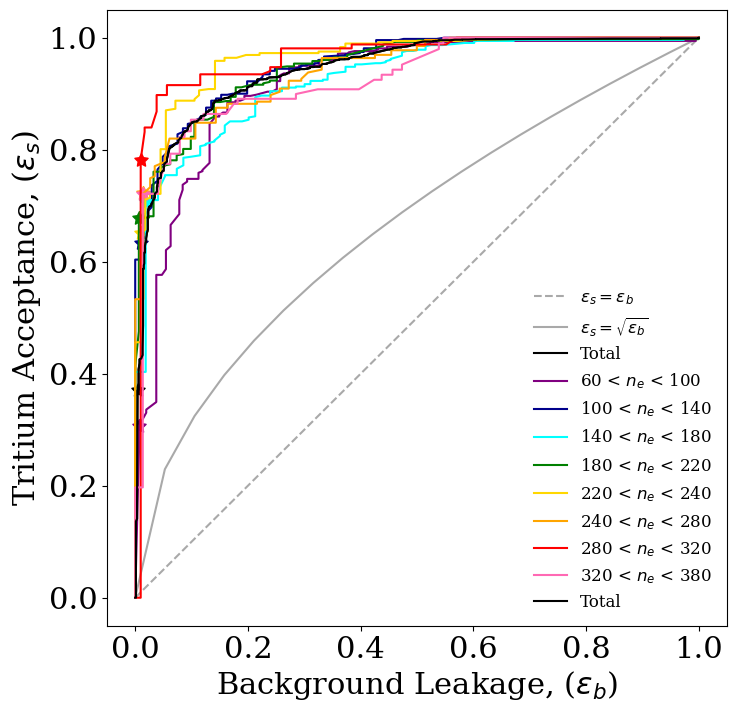

In [21]:
e_s = np.linspace(0, 1, 20)
e_b = np.linspace(0, 1, 20)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(9):
    ax.plot(ROC_params_list[i][0], ROC_params_list[i][1], label = bin_labels[i], color = bin_colors[i])
    ax.scatter(maxes[i][1], maxes[i][0], color = bin_colors[i], s = 100, marker = (5,1))
ax.set_xlabel(r'Background Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)


In [22]:
# splitting into gate and cathode
ROC_params_gate = []
ROC_params_cath = []
ratios_cath = []
ratios_gate = []
maxes_cath = []
maxes_gate = []
bin_counts = []
start = 60
for i in range(8): 
    trit_cut_ = T_test != 'tritium'
    bin_cut = (start < E_test) & (E_test < start + 40)
    start += 40
    gate_cut_ =  T_test != 'cathode' 
    FPR, TPR, TH = roc_curve(Y_test[bin_cut&gate_cut_],Y_score[bin_cut&gate_cut_],sample_weight = W_test[bin_cut&gate_cut_], pos_label = 1)
    ROC_params_gate.append([FPR, TPR, TH])
    ratio_gate = eff_calc(TPR, FPR)
    ratios_gate.append(ratio_gate)
    ind = np.where(ratio_gate == np.max(ratio_gate))
    maxes_gate.append([TPR[ind], FPR[ind]])
    cath_cut_ =  T_test != 'gate' 
    FPR, TPR, TH = roc_curve(Y_test[bin_cut&cath_cut_],Y_score[bin_cut&cath_cut_],sample_weight = W_test[bin_cut&cath_cut_], pos_label = 1)
    ROC_params_cath.append([FPR, TPR, TH])
    ratio_cath = eff_calc(TPR, FPR)
    ratios_cath.append(ratio_cath)
    ind = np.where(ratio_cath == np.max(ratio_cath))
    maxes_cath.append([TPR[ind], FPR[ind]])
    bin_counts.append([len(E_test[bin_cut]), len(E_test[bin_cut&cath_cut_&gate_cut_]), len(E_test[bin_cut&trit_cut_&gate_cut_]), len(E_test[bin_cut&trit_cut_&cath_cut_])])
bin_counts

[[411, 255, 92, 64],
 [615, 492, 77, 46],
 [566, 482, 35, 49],
 [525, 429, 63, 33],
 [426, 342, 64, 20],
 [312, 234, 46, 32],
 [221, 152, 49, 20],
 [189, 105, 55, 29]]

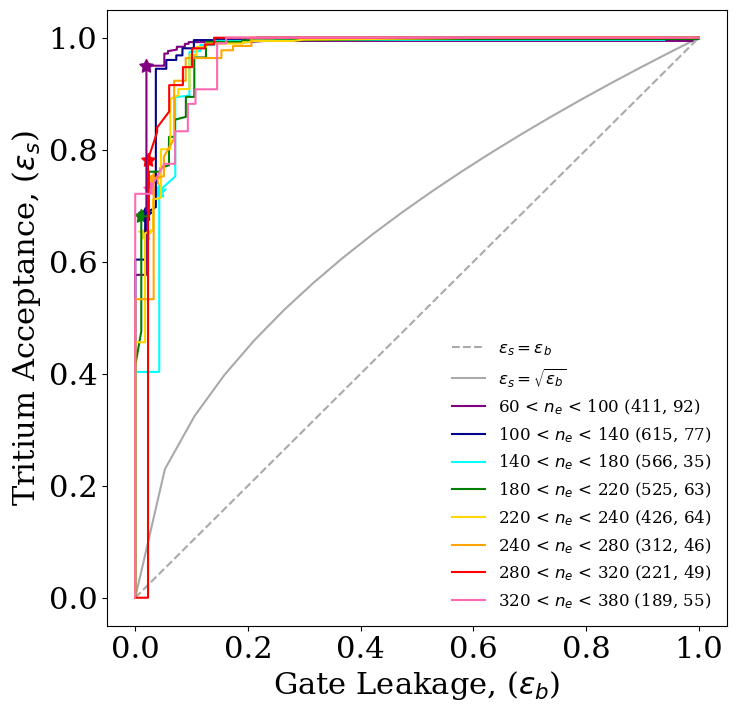

In [23]:
e_s = np.linspace(0, 1, 20)
e_b = np.linspace(0, 1, 20)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(8):
    ax.plot(ROC_params_gate[i][0], ROC_params_gate[i][1], label = '%s (%i, %i)'%(bin_labels[i+1],bin_counts[i][0], bin_counts[i][2]), color = bin_colors[i+1])
    ax.scatter(maxes_gate[i][1], maxes_gate[i][0], color = bin_colors[i+1], s = 100, marker = (5,1))
ax.set_xlabel(r'Gate Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
#ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)

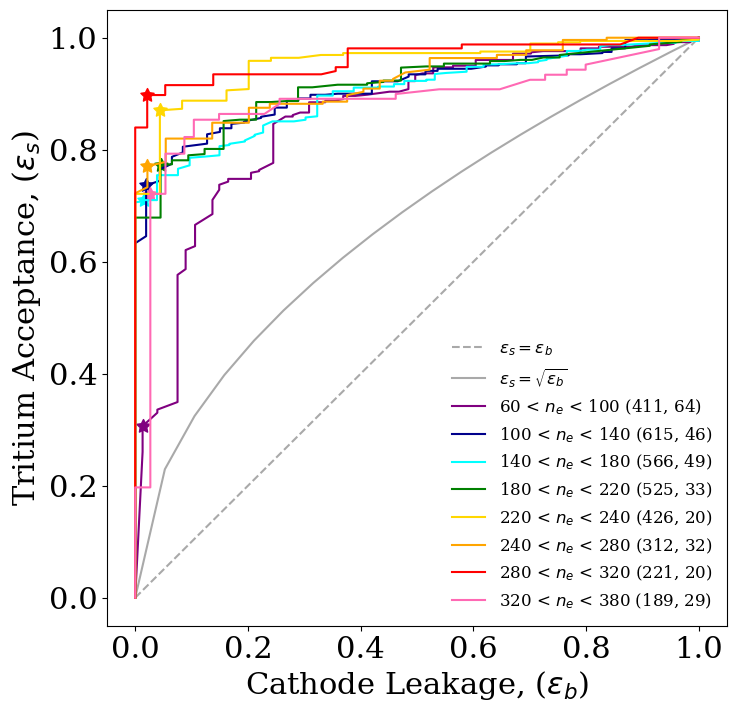

In [24]:
e_s = np.linspace(0, 1, 20)
e_b = np.linspace(0, 1, 20)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(8):
    ax.plot(ROC_params_cath[i][0], ROC_params_cath[i][1], label = '%s (%i, %i)'%(bin_labels[i+1],bin_counts[i][0], bin_counts[i][3]), color = bin_colors[i+1])
    ax.scatter(maxes_cath[i][1], maxes_cath[i][0], color = bin_colors[i+1], s = 100, marker = (5,1))
ax.set_xlabel(r'Cathode Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
#ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)

Text(0, 0.5, 'Discrimination Score')

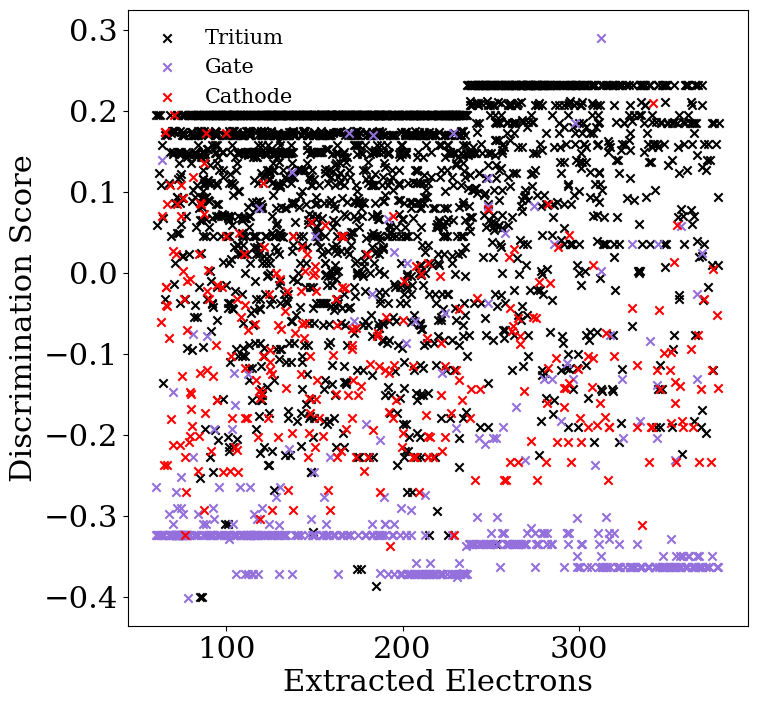

In [25]:
fig, ax = plt.subplots(figsize = (8,8))
#disc_score_axis = hist.axis.Regular(100,-1,1,name="disc_score",
#                           label="Discriminator Score",flow=False)
#disc_score_hist_trit = hist.Hist(electron_axis2, disc_score_axis)
#disc_score_hist_trit.fill(E_test[T_test == 'tritium'], Y_score[T_test == 'tritium'])
#disc_score_hist_trit.plot(norm=mpl.colors.LogNorm(),cmap='Greys', label = 'Tritium')
ax.scatter(E_test[T_test == 'tritium'], Y_score[T_test == 'tritium'], color = 'black', marker = 'x', label = 'Tritium')
ax.scatter(E_test[T_test == 'gate'], Y_score[T_test == 'gate'], color = 'mediumpurple', marker = 'x', label = 'Gate')
ax.scatter(E_test[T_test == 'cathode'], Y_score[T_test == 'cathode'], color = 'red', marker = 'x', label = 'Cathode')
ax.legend(bbox_to_anchor=(0,1),loc='upper left',frameon=False, fontsize = 15)
ax.set_xlabel('Extracted Electrons')
ax.set_ylabel('Discrimination Score')


In [34]:
importances = pd.DataFrame(model.feature_importances_.reshape(8,1), features)

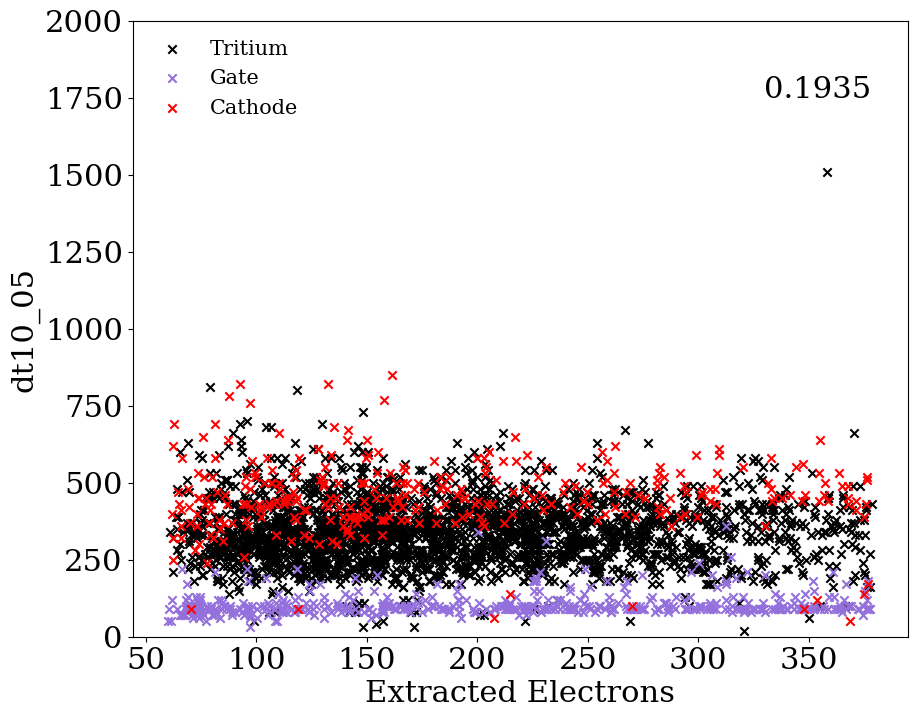

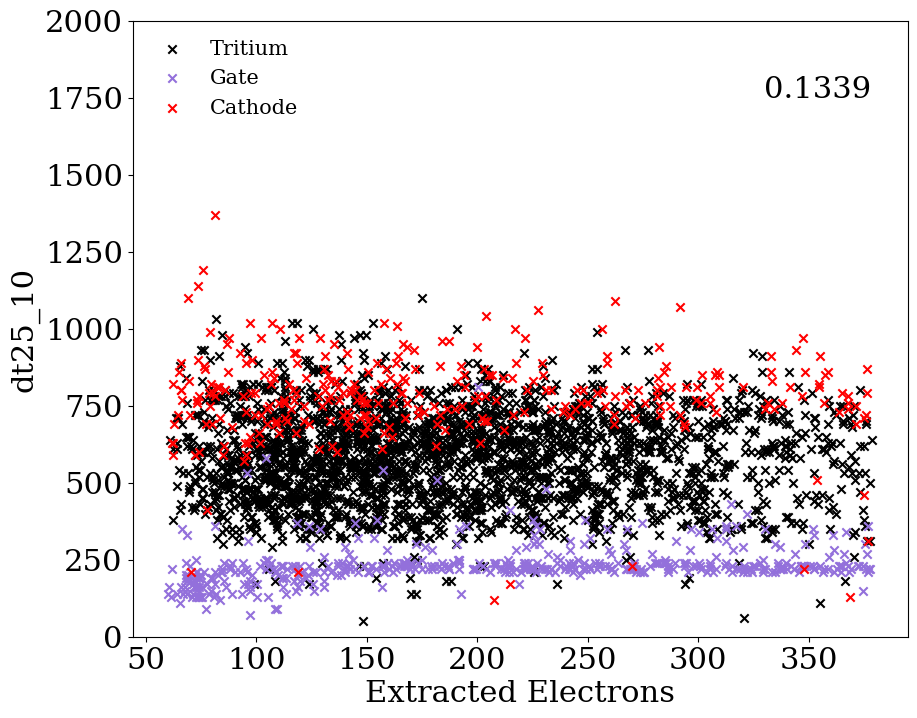

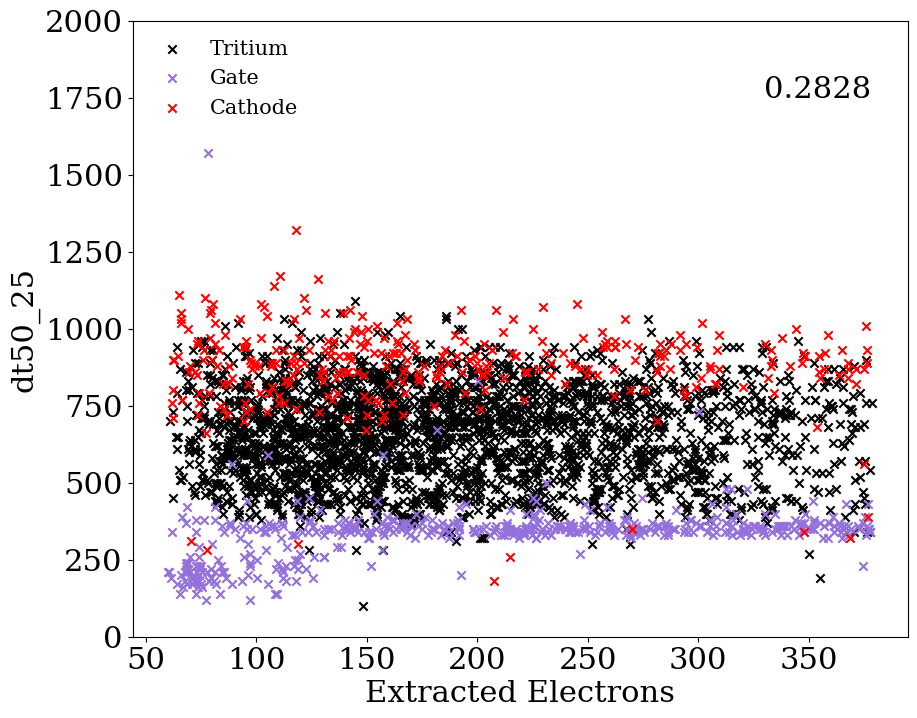

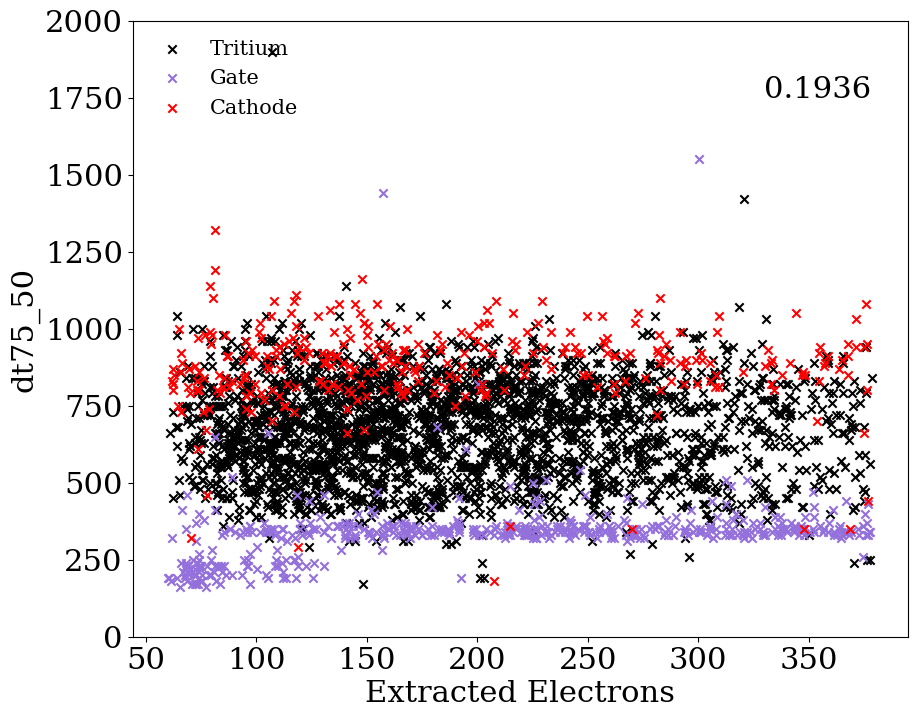

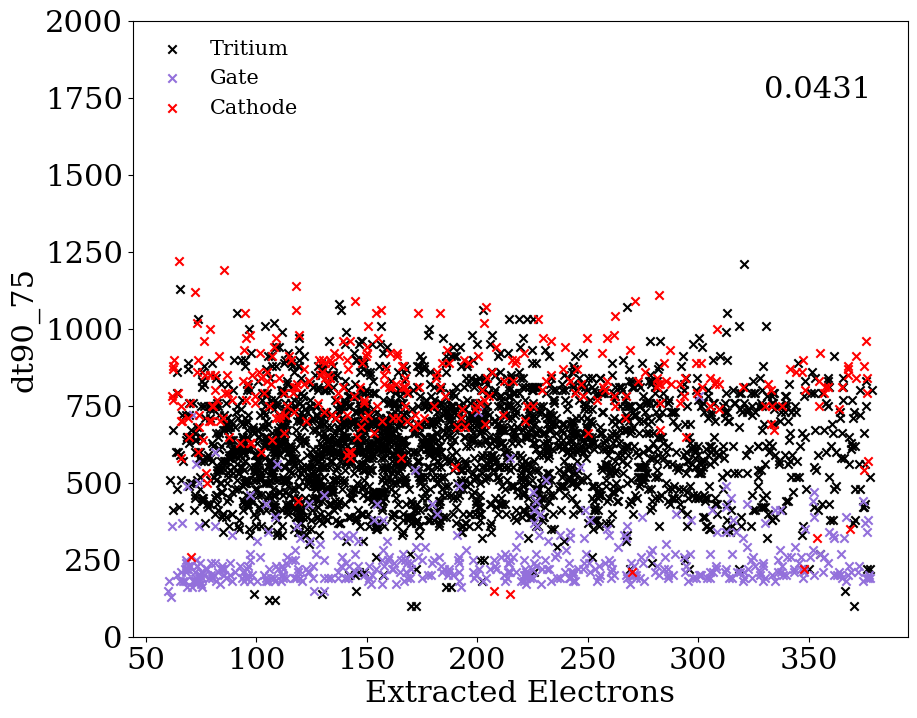

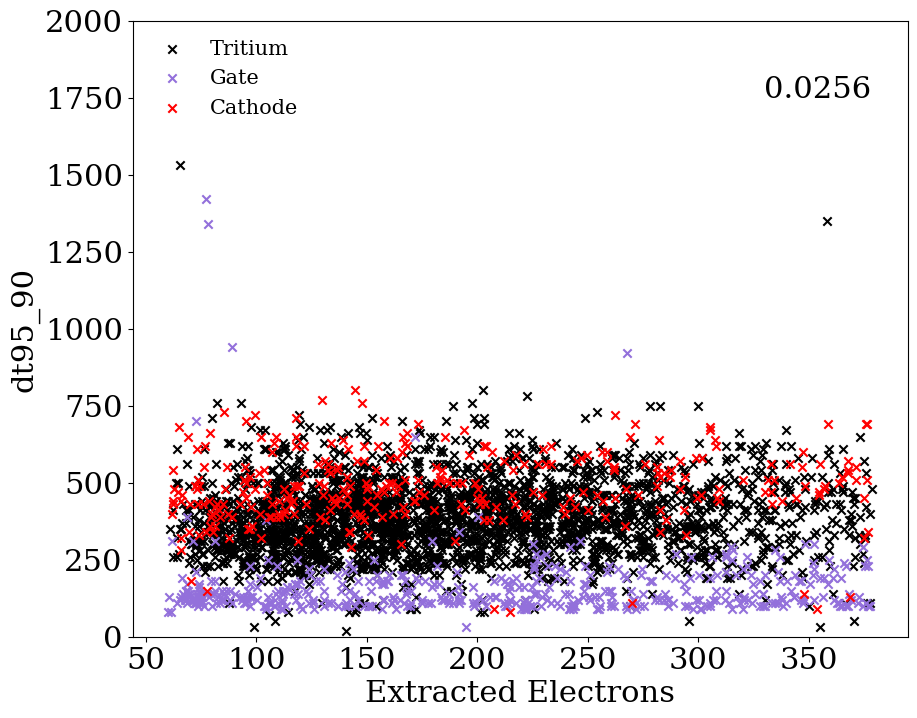

In [35]:
# making parameter plots 
time_labels = ['dt10_05', 'dt25_10', 'dt50_25', 'dt75_50', 'dt90_75', 'dt95_90']
for i in range(6):
    plt.scatter(df_cut_gas.ext_elec[trit_cut2][::4], df_cut_gas[time_labels[i]][trit_cut2][::4], marker = 'x', color = 'black', label = 'Tritium')
    plt.scatter(df_cut_gas.ext_elec[gate_cut2][::4], df_cut_gas[time_labels[i]][gate_cut2][::4], marker = 'x', color = 'mediumpurple', label = 'Gate')
    plt.scatter(df_cut_gas.ext_elec[cath_cut2][::4], df_cut_gas[time_labels[i]][cath_cut2][::4], marker = 'x', color = 'red', label = 'Cathode')
    plt.text(330, 1750, np.round(importances[0][i+1], 4))
    plt.legend(bbox_to_anchor=(0,1),loc='upper left',frameon=False, fontsize = 15)
    plt.ylabel(time_labels[i])
    plt.xlabel('Extracted Electrons')
    plt.ylim([0,2000])
    plt.savefig(time_labels[i])
    plt.show()

Text(300, 25, '0.1091')

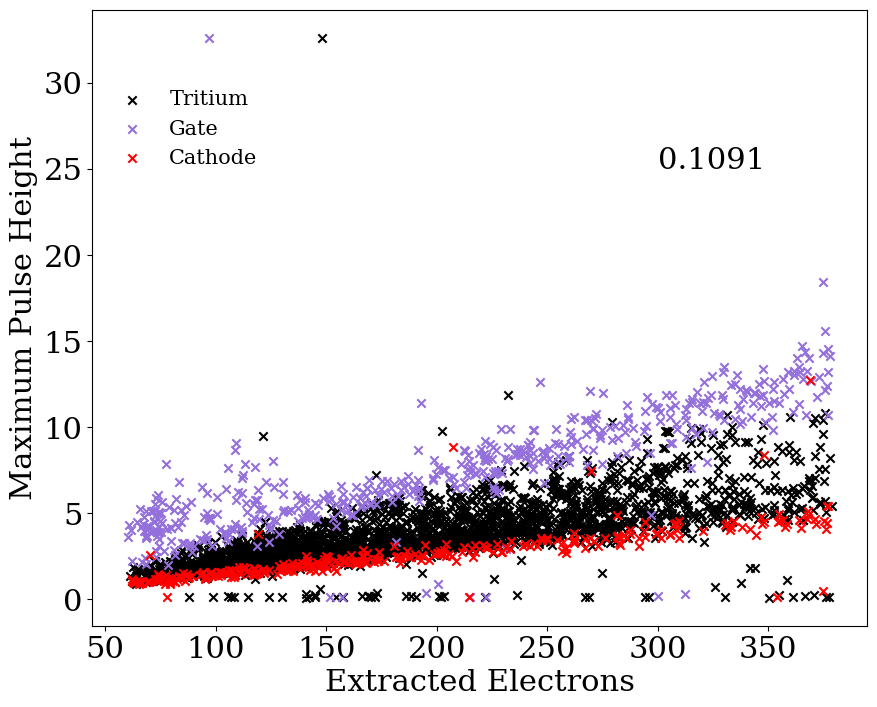

In [36]:
plt.scatter(df_cut_gas.ext_elec[trit_cut2][::4], df_cut_gas['max_pulse_height'][trit_cut2][::4], marker = 'x', color = 'black', label = 'Tritium')
plt.scatter(df_cut_gas.ext_elec[gate_cut2][::4], df_cut_gas['max_pulse_height'][gate_cut2][::4], marker = 'x', color = 'mediumpurple', label = 'Gate')
plt.scatter(df_cut_gas.ext_elec[cath_cut2][::4], df_cut_gas['max_pulse_height'][cath_cut2][::4], marker = 'x', color = 'red', label = 'Cathode')
plt.xlabel('Extracted Electrons')
plt.ylabel('Maximum Pulse Height')
plt.legend(bbox_to_anchor=(0,0.9),loc='upper left',frameon=False, fontsize = 15)
plt.text(300, 25, np.round(importances[0][0], 4))


In [37]:
# ML for only pulse width 

features2 = ['S2_width', 'ext_elec']

X2 = df_cut[features2]
Y2 = df_cut['label']
T2 = df_cut['type']
W2 = df_cut['weights_no_gas'] # - should this be the weight calculated above? 
A2 = df_cut['area']
R2 = df_cut['r']
X2_raw = df_cut['x']
Y2_raw = df_cut['y']
X2_train_unscaled, X2_test_unscaled, \
Y2_train, Y2_test, \
A2_train, A2_test, \
T2_train, T2_test, \
W2_train, W2_test, \
R2_train, R2_test, \
X2_raw_train, X2_raw_test, \
Y2_raw_train, Y2_raw_test = \
train_test_split(X2, Y2, A2, T2, W2, R2, X2_raw, Y2_raw, random_state=0)

In [38]:
scaler = MinMaxScaler()
X2_train = scaler.fit_transform(X2_train_unscaled.astype('float64'))
X2_test = scaler.transform(X2_test_unscaled.astype('float64'))
E2_test = A2_test/SE_size

In [39]:
DTC2 = DecisionTreeClassifier(max_depth=2,min_samples_split=2)
ABC2 = AdaBoostClassifier(base_estimator=DTC2,n_estimators=100,algorithm = 'SAMME')
model2 = ABC2.fit(X2_train, Y2_train.values.ravel()
                ,sample_weight=W2_train.values.ravel().astype('float64'))

Y2_score = model2.decision_function(X2_test)

model2.score(X2_train, Y2_train, sample_weight=W2_train.astype('float64')), \
model2.score(X2_test, Y2_test, sample_weight=W2_test.astype('float64')) 

C:\Users\lizzi\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


(0.7928710742089133, 0.7695774193152575)

In [40]:
FPR2, TPR2, TH2 = roc_curve(Y2_test, Y2_score, sample_weight = W2_test, pos_label = 1)
ROC_params_list2 = [[FPR2, TPR2, TH2]]
start = 60
Y2_score = model2.decision_function(X2_test)
ratio2 = eff_calc(TPR2, FPR2)
ind = np.where(ratio2 == np.max(ratio2))
maxes2 = [[TPR2[ind], FPR2[ind]]]
ratios_list2 = []

for i in range(8): 
    bin_cut = (start < E2_test) & (E2_test < start + 40)
    start += 40
    FPR, TPR, TH = roc_curve(Y2_test[bin_cut],Y2_score[bin_cut],sample_weight = W2_test[bin_cut], pos_label = 1)
    ROC_params_list2.append([FPR, TPR, TH])
    ratios = eff_calc(TPR, FPR)
    ratios_list2.append(ratios)
    ind = np.where(ratios == np.max(ratios))
    maxes2.append([TPR[ind], FPR[ind]])

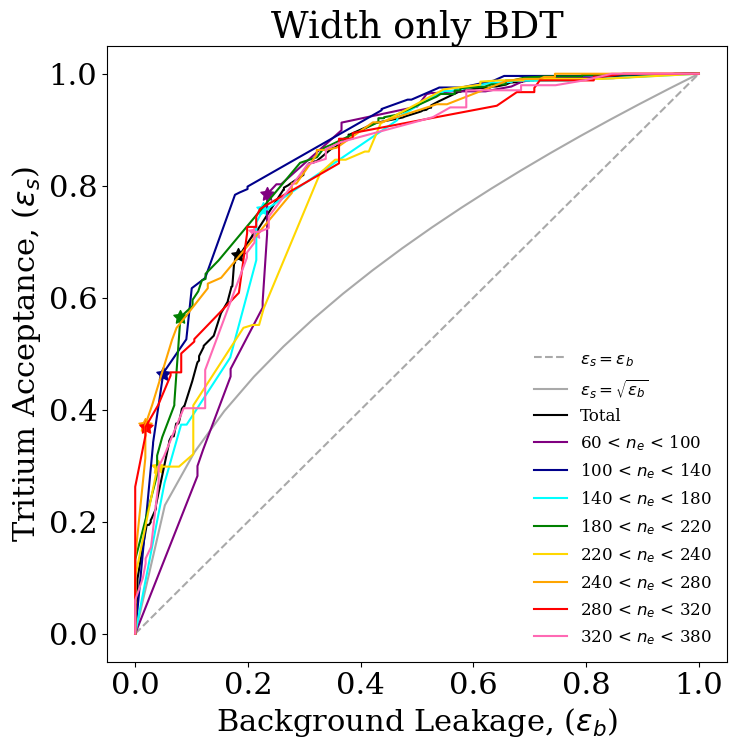

In [41]:
e_s = np.linspace(0, 1, 20)
e_b = np.linspace(0, 1, 20)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(9):
    ax.plot(ROC_params_list2[i][0], ROC_params_list2[i][1], label = bin_labels[i], color = bin_colors[i])
    ax.scatter(maxes2[i][1], maxes2[i][0], color = bin_colors[i], s = 100, marker = (5,1))
ax.set_xlabel(r'Background Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
ax.set_title('Width only BDT')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)


In [42]:
# splitting into gate and cathode
ROC_params_gate2 = []
ROC_params_cath2 = []
ratios_gate2 = []
ratios_cath2 = []
maxes_cath2= []
maxes_gate2 = []
start = 60
for i in range(8): 
    bin_cut = (start < E2_test) & (E2_test < start + 40)
    start += 40
    gate_cut_ =  T2_test != 'cathode' 
    FPR, TPR, TH = roc_curve(Y2_test[bin_cut&gate_cut_],Y2_score[bin_cut&gate_cut_],sample_weight = W2_test[bin_cut&gate_cut_], pos_label = 1)
    ROC_params_gate2.append([FPR, TPR, TH])
    ratio_gate = eff_calc(TPR, FPR)
    ratios_gate2.append(ratio_gate)
    ind = np.where(ratio_gate == np.max(ratio_gate))
    maxes_gate2.append([TPR[ind], FPR[ind]])
    cath_cut_ =  T_test != 'gate' 
    FPR, TPR, TH = roc_curve(Y2_test[bin_cut&cath_cut_],Y2_score[bin_cut&cath_cut_],sample_weight = W2_test[bin_cut&cath_cut_], pos_label = 1)
    ROC_params_cath2.append([FPR, TPR, TH])
    ratio_cath = eff_calc(TPR, FPR)
    ratios_cath2.append(ratio_gate)
    ind = np.where(ratio_gate == np.max(ratio_gate))
    maxes_cath2.append([TPR[ind], FPR[ind]])


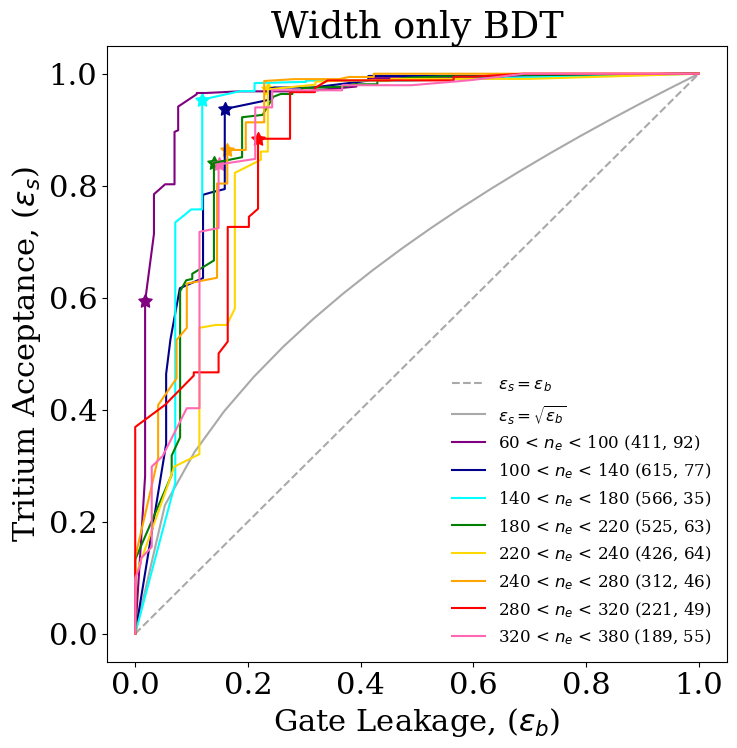

In [43]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(8):
    ax.plot(ROC_params_gate2[i][0], ROC_params_gate2[i][1], label = '%s (%i, %i)'%(bin_labels[i+1],bin_counts[i][0], bin_counts[i][2]), color = bin_colors[i+1])
    ax.scatter(maxes_gate2[i][1], maxes_gate2[i][0], color = bin_colors[i+1], s = 100, marker = (5,1))
ax.set_xlabel(r'Gate Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
ax.set_title('Width only BDT')
#ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)

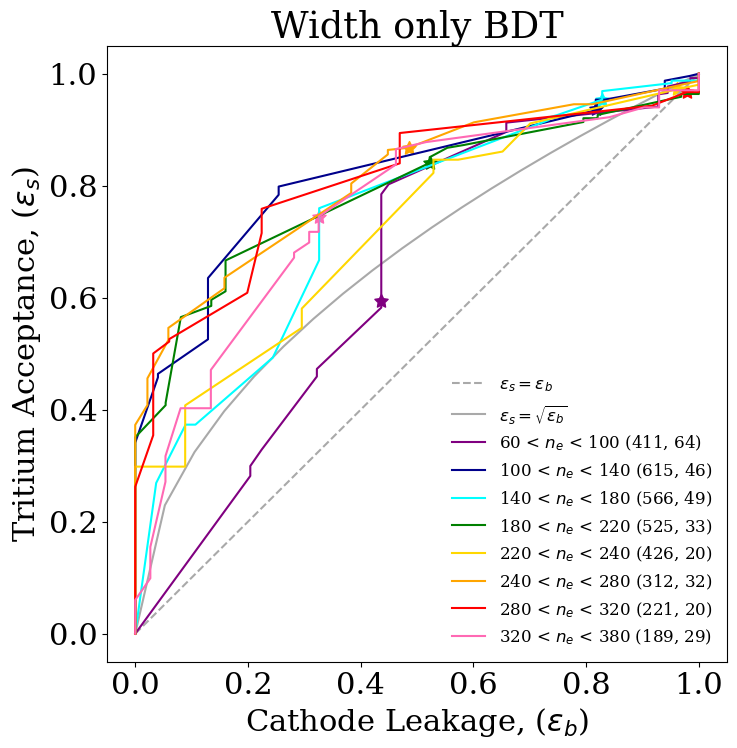

In [44]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(8):
    ax.plot(ROC_params_cath2[i][0], ROC_params_cath2[i][1], label = '%s (%i, %i)'%(bin_labels[i+1],bin_counts[i][0], bin_counts[i][3]), color = bin_colors[i+1])
    ax.scatter(maxes_cath2[i][1], maxes_cath2[i][0], color = bin_colors[i+1], s = 100, marker = (5,1))
ax.set_xlabel(r'Cathode Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
#ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.set_title('Width only BDT')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)

In [45]:
model2.feature_importances_

array([0.7528227, 0.2471773])

Text(300, 20000, '0.7528')

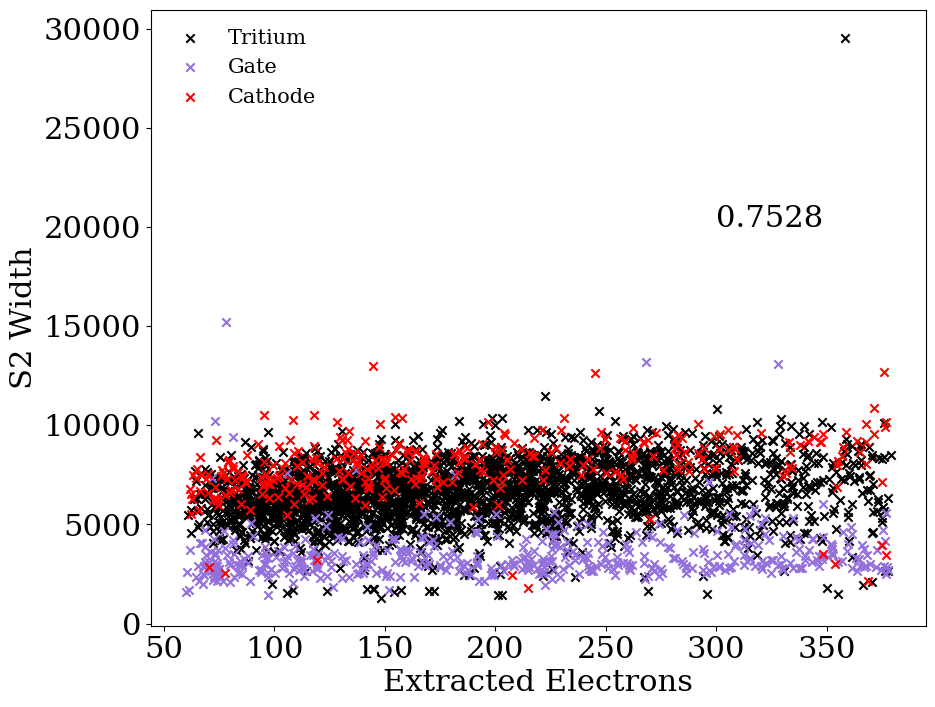

In [46]:
plt.scatter(df_cut_gas.ext_elec[trit_cut2][::4], df_cut_gas['S2_width'][trit_cut2][::4], marker = 'x', color = 'black', label = 'Tritium')
plt.scatter(df_cut_gas.ext_elec[gate_cut2][::4], df_cut_gas['S2_width'][gate_cut2][::4], marker = 'x', color = 'mediumpurple', label = 'Gate')
plt.scatter(df_cut_gas.ext_elec[cath_cut2][::4], df_cut_gas['S2_width'][cath_cut2][::4], marker = 'x', color = 'red', label = 'Cathode')
plt.xlabel('Extracted Electrons')
plt.ylabel('S2 Width')
plt.legend(bbox_to_anchor=(0,1),loc='upper left',frameon=False, fontsize = 15)
plt.text(300, 20000, np.round(model2.feature_importances_[0], 4))


Text(0.5, 1.0, 'Width Only BDT')

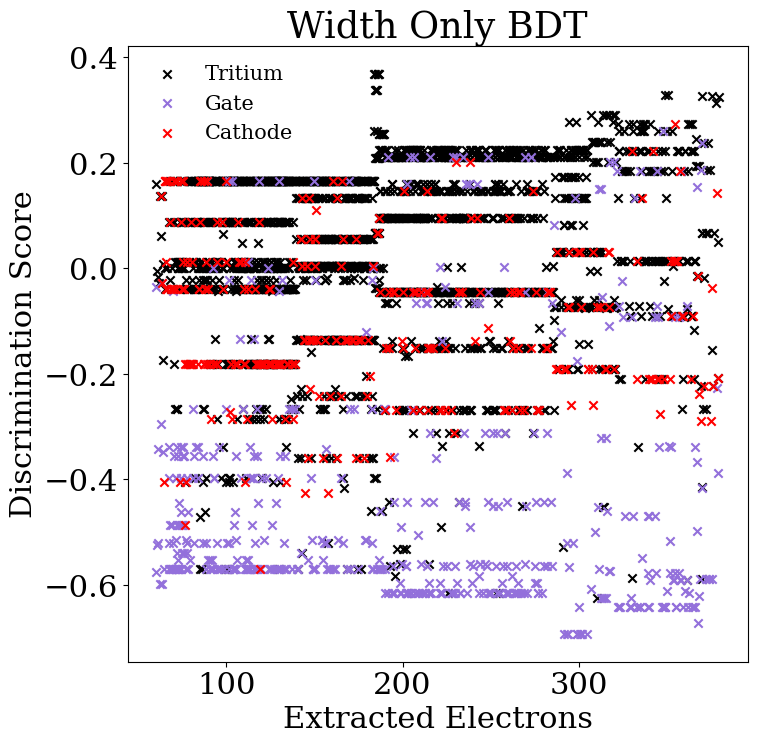

In [47]:
E2_test = A2_test/SE_size
fig, ax = plt.subplots(figsize = (8,8))
#disc_score_axis = hist.axis.Regular(100,-1,1,name="disc_score",
#                           label="Discriminator Score",flow=False)
#disc_score_hist_trit = hist.Hist(electron_axis2, disc_score_axis)
#disc_score_hist_trit.fill(E_test[T_test == 'tritium'], Y_score[T_test == 'tritium'])
#disc_score_hist_trit.plot(norm=mpl.colors.LogNorm(),cmap='Greys', label = 'Tritium')
ax.scatter(E2_test[T2_test == 'tritium'], Y2_score[T2_test == 'tritium'], color = 'black', marker = 'x', label = 'Tritium')
ax.scatter(E2_test[T2_test == 'gate'], Y2_score[T2_test == 'gate'], color = 'mediumpurple', marker = 'x', label = 'Gate')
ax.scatter(E2_test[T2_test == 'cathode'], Y2_score[T2_test == 'cathode'], color = 'red', marker = 'x', label = 'Cathode')
ax.legend(bbox_to_anchor=(0,1),loc='upper left',frameon=False, fontsize = 15)
ax.set_xlabel('Extracted Electrons')
ax.set_ylabel('Discrimination Score')
ax.set_title('Width Only BDT')


In [48]:
bin1 = (60 < E_test) & (E_test < 100) 
bin2 = (100 < E_test) & (E_test < 140) 
bin3 = (140 < E_test) & (E_test < 180) 
bin4 = (180 < E_test) & (E_test < 220) 
bin5 = (220 < E_test) & (E_test < 260) 
bin6 = (260 < E_test) & (E_test < 300) 
bin7 = (300 < E_test) & (E_test < 340) 
bin8 = (340 < E_test) & (E_test < 380) 
bin_cuts = [bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8] 


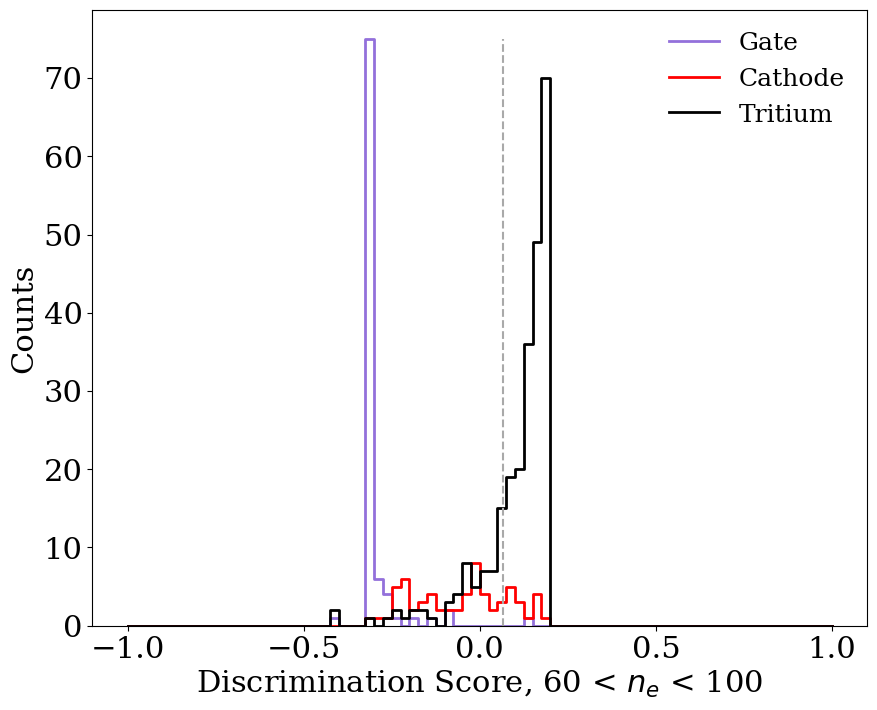

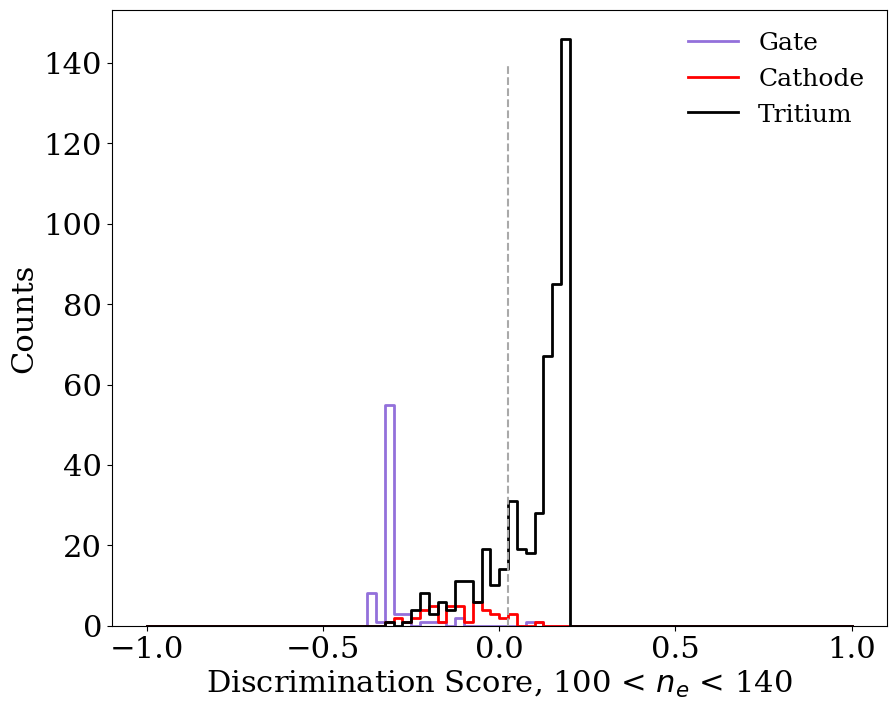

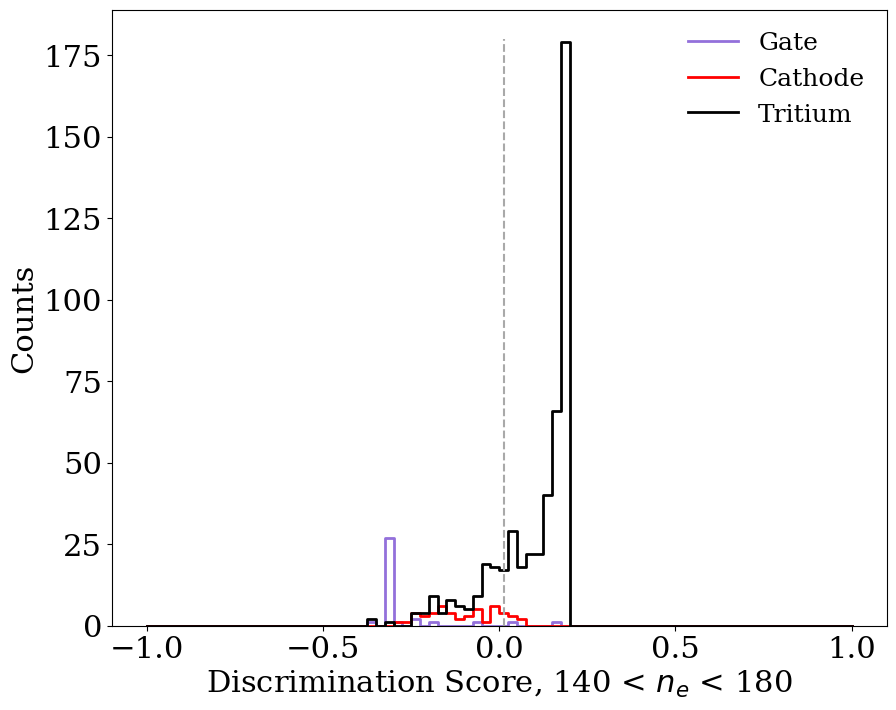

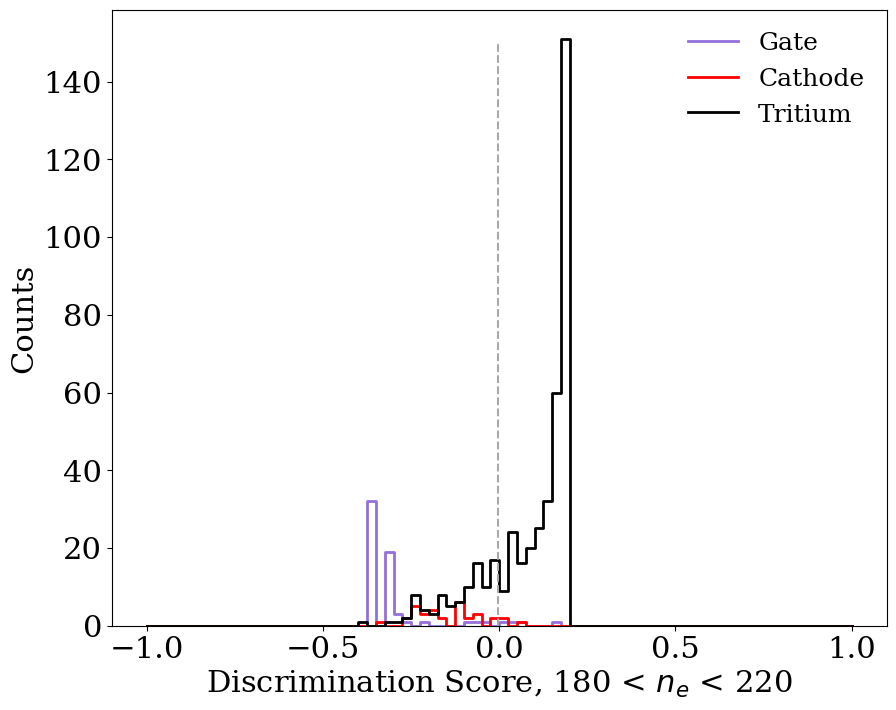

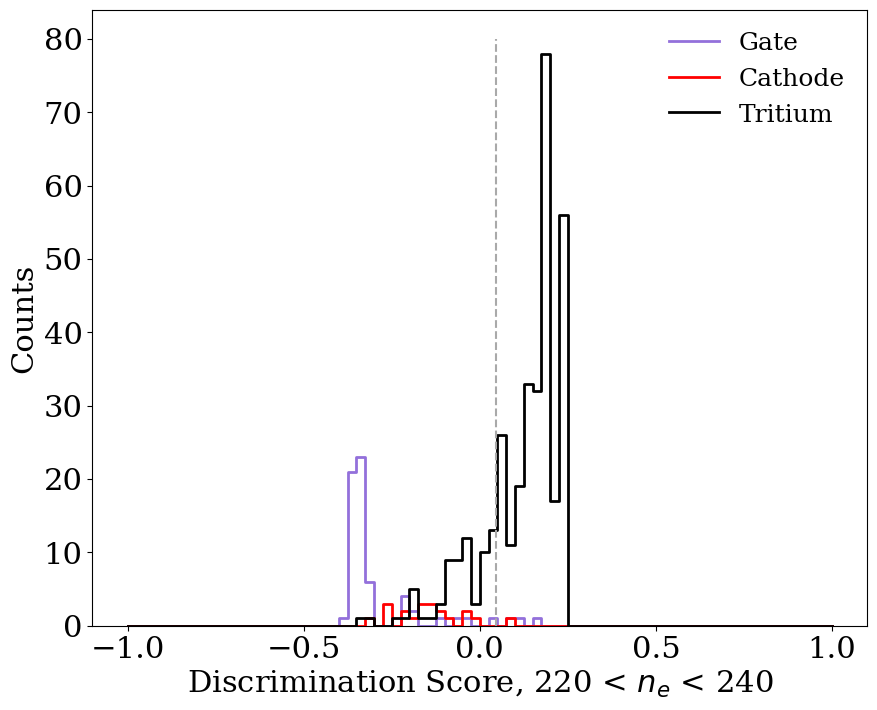

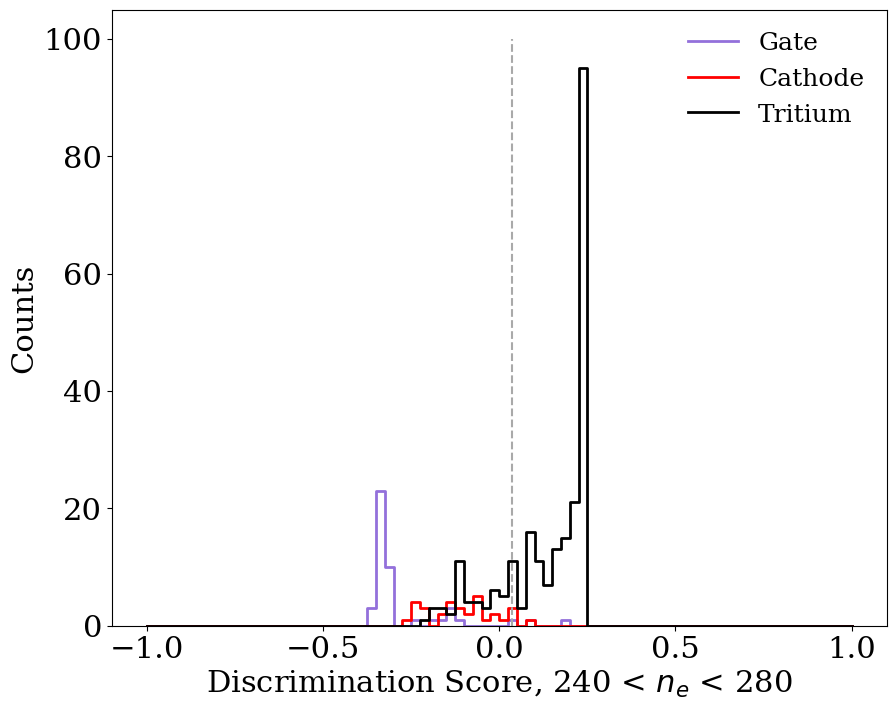

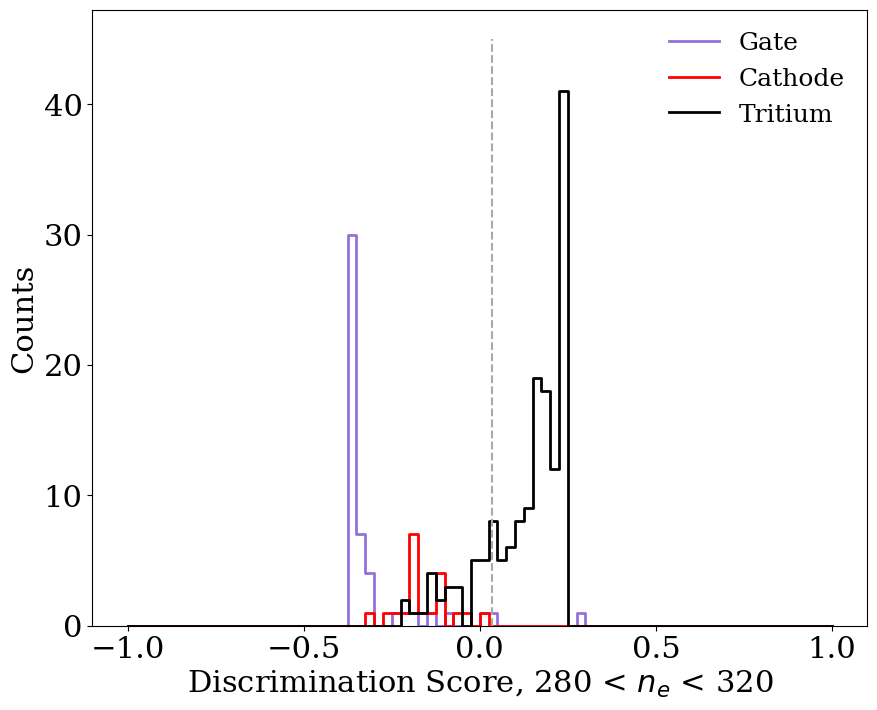

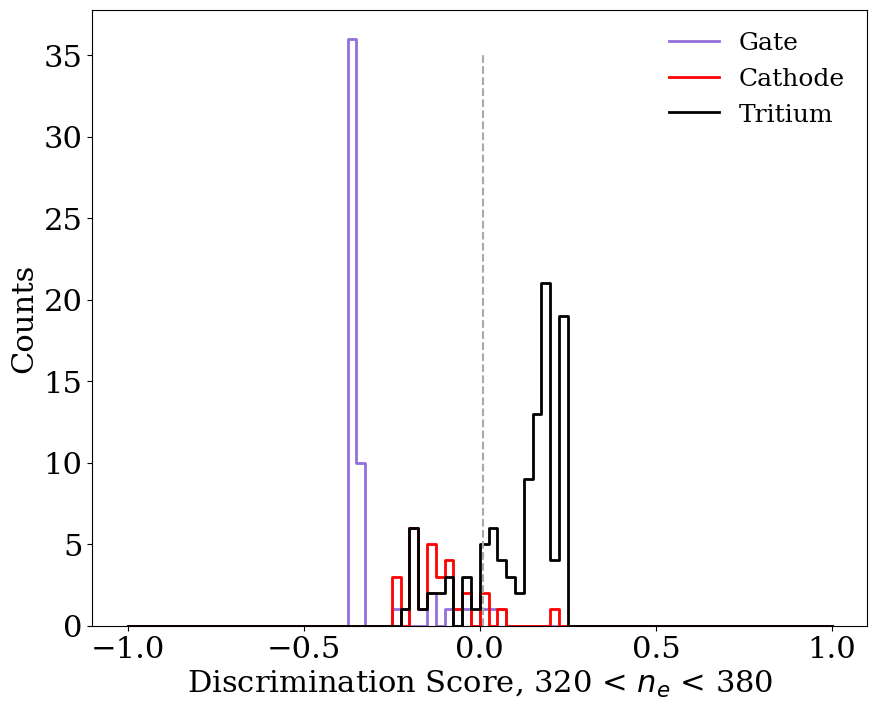

In [49]:
tops = [75,140,180,150,80,100,45,35]
y_score_axis =  hist.axis.Regular(80,-1,1,name="disc_score", label="Discrimination Score",flow=False)
cutoffs = []
disc_cuts = []
trit_effs = [[],[]]
cath_effs = [[],[]]
gate_effs = [[],[]]
for i in range(8):

    trit_score_hist = Hist(y_score_axis)
    trit_cut = T_test == 'tritium'
    trit_score_hist.fill(Y_score[trit_cut&bin_cuts[i]])

    gate_score_hist = Hist(y_score_axis)
    gate_cut = T_test == 'gate'
    gate_score_hist.fill(Y_score[gate_cut&bin_cuts[i]])

    cath_score_hist = Hist(y_score_axis)
    cath_cut = T_test == 'cathode'
    cath_score_hist.fill(Y_score[cath_cut&bin_cuts[i]])

    fig, ax = plt.subplots(figsize=(10, 8))
    gate_score_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
    cath_score_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
    trit_score_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
    
    loc = int(np.round(len(Y_score[trit_cut&bin_cuts[i]])*0.2)) 
    cutoff = np.sort(Y_score[trit_cut&bin_cuts[i]])[loc]
    cutoffs.append(cutoff)
    disc_cut = Y_score > cutoff
    disc_cuts.append(disc_cut)
    
    trit_eff = len(E_test[bin_cuts[i]&trit_cut&disc_cut])/len(E_test[bin_cuts[i]&trit_cut])
    trit_err = np.sqrt(len(E_test[bin_cuts[i]&trit_cut&disc_cut]))/len(E_test[bin_cuts[i]&trit_cut])
    trit_effs[0].append(trit_eff)
    trit_effs[1].append(trit_err)
    
    
    gate_eff = 1 - len(E_test[bin_cuts[i]&gate_cut&disc_cut])/len(E_test[bin_cuts[i]&gate_cut])
    gate_err = np.sqrt(len(E_test[bin_cuts[i]&gate_cut&disc_cut]))/len(E_test[bin_cuts[i]&gate_cut])
    gate_effs[0].append(gate_eff)
    gate_effs[1].append(gate_err)
    
    cath_eff = 1 - len(E_test[bin_cuts[i]&cath_cut&disc_cut])/len(E_test[bin_cuts[i]&cath_cut])
    cath_err = np.sqrt(len(E_test[bin_cuts[i]&cath_cut&disc_cut]))/len(E_test[bin_cuts[i]&cath_cut])
    cath_effs[0].append(cath_eff)
    cath_effs[1].append(cath_err)
    
    ax.set(xlabel='Discrimination Score, %s'%(bin_labels[i+1]),ylabel='Counts')
    ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)
    ax.plot([cutoff,cutoff], [0,tops[i]], linestyle='--', color='darkgray')
    
    plt.savefig('%s'%(i))
    plt.show()



Text(0, 0.5, 'Acceptance or Rejection')

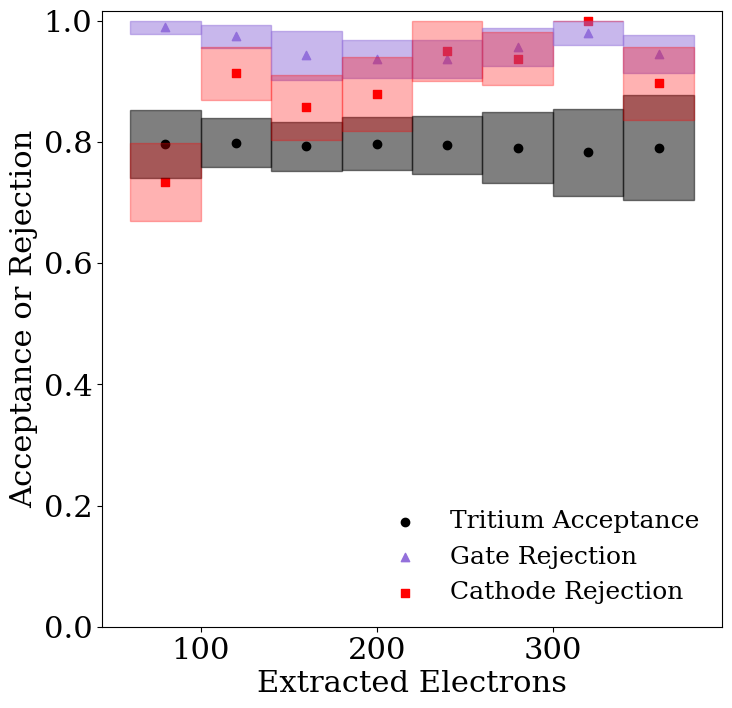

In [50]:
bin_centres = [80, 120, 160, 200, 240, 280, 320, 360]
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(bin_centres, trit_effs[0], label = 'Tritium Acceptance', color = 'black')
ax.scatter(bin_centres, gate_effs[0], label = 'Gate Rejection', color = 'mediumpurple', marker = '^')
ax.scatter(bin_centres, cath_effs[0], label = 'Cathode Rejection', color = 'red', marker = 's')

for i in range(8):
    trit_rec = Rectangle((bin_centres[i]-20, trit_effs[0][i]-trit_effs[1][i]), 40, 2*trit_effs[1][i], color = 'black', alpha = 0.5)
    gate_rec = Rectangle((bin_centres[i]-20, gate_effs[0][i]-gate_effs[1][i]), 40, 2*gate_effs[1][i], color = 'mediumpurple', alpha = 0.5)
    cath_rec = Rectangle((bin_centres[i]-20, cath_effs[0][i]-cath_effs[1][i]), 40, 2*cath_effs[1][i], color = 'red', alpha = 0.3)
    ax.add_patch(trit_rec)
    ax.add_patch(gate_rec)
    ax.add_patch(cath_rec)
ax.set_ylim(0)
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 18)
ax.set_xlabel('Extracted Electrons')
ax.set_ylabel('Acceptance or Rejection')

In [51]:
bin_counts

[[411, 255, 92, 64],
 [615, 492, 77, 46],
 [566, 482, 35, 49],
 [525, 429, 63, 33],
 [426, 342, 64, 20],
 [312, 234, 46, 32],
 [221, 152, 49, 20],
 [189, 105, 55, 29]]

In [93]:
cutoffs2 = []
disc_cuts2 = []
trit_effs2 = [[],[]]
cath_effs2 = [[],[]]
gate_effs2 = [[],[]]
trit_cut_data = {'data':[]}
cath_cut_data = {'data':[]}
gate_cut_data = {'data':[]}
tops2 = [90,170,130,105,105,75,30,25]
for i in range(8):

    trit_score_hist2 = Hist(y_score_axis)
    trit_cut = T2_test == 'tritium'
    trit_score_hist2.fill(Y2_score[trit_cut&bin_cuts[i]])

    gate_score_hist2 = Hist(y_score_axis)
    gate_cut = T2_test == 'gate'
    gate_score_hist2.fill(Y2_score[gate_cut&bin_cuts[i]])

    cath_score_hist2 = Hist(y_score_axis)
    cath_cut = T2_test == 'cathode'
    cath_score_hist2.fill(Y2_score[cath_cut&bin_cuts[i]])

    #fig, ax = plt.subplots(figsize=(10, 8))
    #gate_score_hist2.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
    #cath_score_hist2.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
    #trit_score_hist2.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
    
    loc = int(np.round(len(Y2_score[trit_cut&bin_cuts[i]])*0.2)) 
    cutoff = np.sort(Y2_score[trit_cut&bin_cuts[i]])[loc]
    cutoffs2.append(cutoff)
    disc_cut = Y2_score > cutoff
    disc_cuts2.append(disc_cut)
    
    trit_eff = len(E2_test[bin_cuts[i]&trit_cut&disc_cut])/len(E2_test[bin_cuts[i]&trit_cut])
    trit_err = np.sqrt(len(E2_test[bin_cuts[i]&trit_cut&disc_cut]))/len(E2_test[bin_cuts[i]&trit_cut])
    trit_effs2[0].append(trit_eff)
    trit_effs2[1].append(trit_err)
    trit_cut_data['data'] = trit_cut_data['data'] + list(width_test[bin_cuts[i]&trit_cut&disc_cut])
    
    gate_eff = 1 - len(E2_test[bin_cuts[i]&gate_cut&disc_cut])/len(E2_test[bin_cuts[i]&gate_cut])
    gate_err = np.sqrt(len(E2_test[bin_cuts[i]&gate_cut&disc_cut]))/len(E2_test[bin_cuts[i]&gate_cut])
    gate_effs2[0].append(gate_eff)
    gate_effs2[1].append(gate_err)
    gate_cut_data['data'] = gate_cut_data['data'] + list(width_test[bin_cuts[i]&gate_cut&disc_cut])

    
    cath_eff = 1 - len(E2_test[bin_cuts[i]&cath_cut&disc_cut])/len(E2_test[bin_cuts[i]&cath_cut])
    cath_err = np.sqrt(len(E2_test[bin_cuts[i]&cath_cut&disc_cut]))/len(E2_test[bin_cuts[i]&cath_cut])
    cath_effs2[0].append(cath_eff)
    cath_effs2[1].append(cath_err)
    cath_cut_data['data'] = cath_cut_data['data'] + list(width_test[bin_cuts[i]&cath_cut&disc_cut])

    
    
    #ax.set(xlabel='Discrimination Score, %s'%(bin_labels[i+1]),ylabel='Counts')
    #ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)
    #ax.plot([cutoff,cutoff], [0,tops2[i]], linestyle='--', color='darkgray')
    
    #plt.savefig('%s'%(i))
    
    #plt.show()
    

Text(0, 0.5, 'Acceptance or Rejection ')

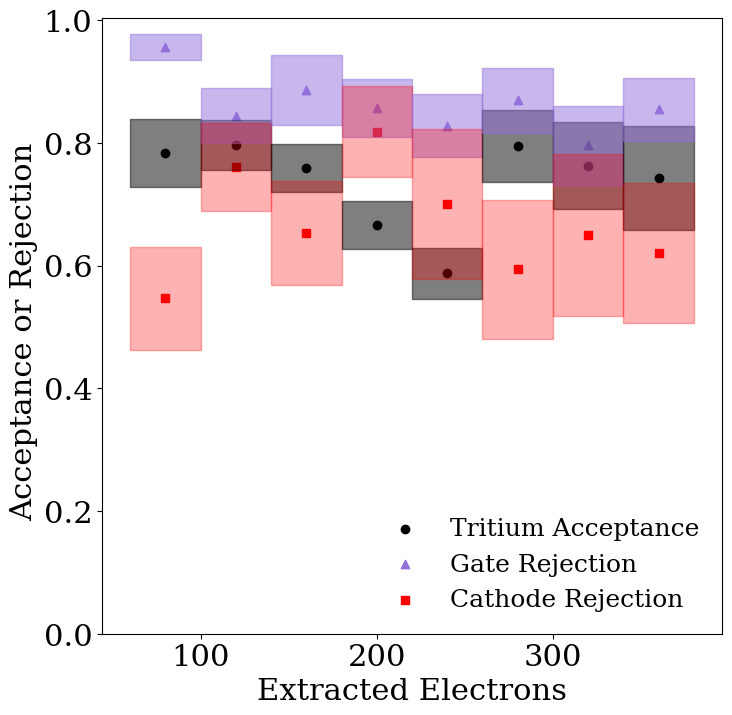

In [53]:
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(bin_centres, trit_effs2[0], label = 'Tritium Acceptance', color = 'black')
ax.scatter(bin_centres, gate_effs2[0], label = 'Gate Rejection', color = 'mediumpurple', marker = '^')
ax.scatter(bin_centres, cath_effs2[0], label = 'Cathode Rejection', color = 'red', marker = 's')

for i in range(8):
    trit_rec = Rectangle((bin_centres[i]-20, trit_effs2[0][i]-trit_effs2[1][i]), 40, 2*trit_effs2[1][i], color = 'black', alpha = 0.5)
    gate_rec = Rectangle((bin_centres[i]-20, gate_effs2[0][i]-gate_effs2[1][i]), 40, 2*gate_effs2[1][i], color = 'mediumpurple', alpha = 0.5)
    cath_rec = Rectangle((bin_centres[i]-20, cath_effs2[0][i]-cath_effs2[1][i]), 40, 2*cath_effs2[1][i], color = 'red', alpha = 0.3)
    ax.add_patch(trit_rec)
    ax.add_patch(gate_rec)
    ax.add_patch(cath_rec)
ax.set_ylim(0)
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 18)
ax.set_xlabel('Extracted Electrons')
ax.set_ylabel('Acceptance or Rejection ')

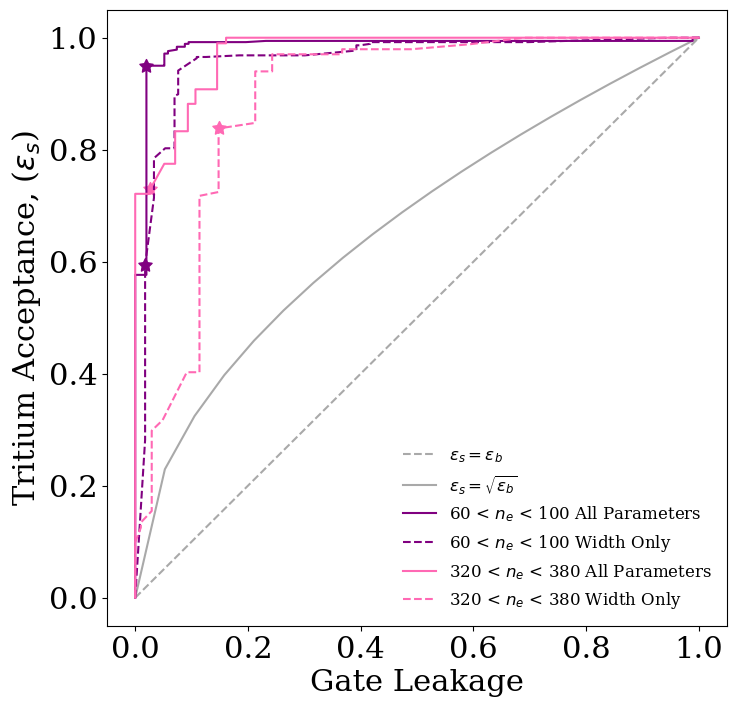

In [54]:
# comparing ROC curves 
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
ax.plot(ROC_params_gate[0][0], ROC_params_gate[0][1], label = '%s All Parameters'%(bin_labels[1]), color = bin_colors[1])
ax.scatter(maxes_gate[0][1], maxes_gate[0][0], color = bin_colors[1], s = 100, marker = (5,1))
ax.plot(ROC_params_gate2[0][0], ROC_params_gate2[0][1], label = '%s Width Only'%(bin_labels[1]), color = bin_colors[1], ls = '--')
ax.scatter(maxes_gate2[0][1], maxes_gate2[0][0], color = bin_colors[1], s = 100, marker = (5,1))
ax.plot(ROC_params_gate[7][0], ROC_params_gate[7][1], label = '%s All Parameters'%(bin_labels[8]), color = bin_colors[8])
ax.scatter(maxes_gate[7][1], maxes_gate[7][0], color = bin_colors[8], s = 100, marker = (5,1))
ax.set_xlabel(r'Gate Leakage, ($\epsilon_b$)')
ax.plot(ROC_params_gate2[7][0], ROC_params_gate2[7][1], label = '%s Width Only'%(bin_labels[8]), color = bin_colors[8], ls = '--')
ax.scatter(maxes_gate2[7][1], maxes_gate2[7][0], color = bin_colors[8], s = 100, marker = (5,1))

ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
ax.set_xlabel('Gate Leakage')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)

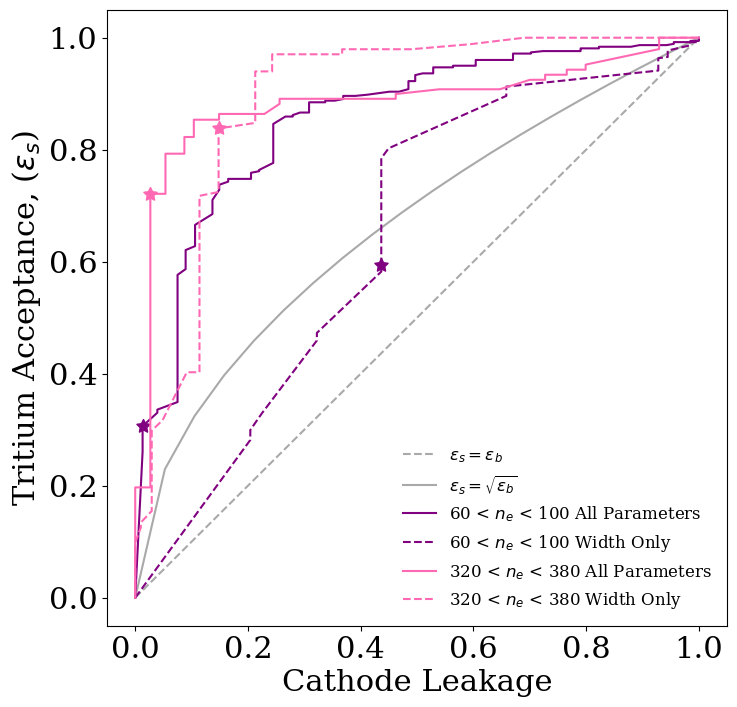

In [55]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
ax.plot(ROC_params_cath[0][0], ROC_params_cath[0][1], label = '%s All Parameters'%(bin_labels[1]), color = bin_colors[1])
ax.scatter(maxes_cath[0][1], maxes_cath[0][0], color = bin_colors[1], s = 100, marker = (5,1))
ax.plot(ROC_params_cath2[0][0], ROC_params_cath2[0][1], label = '%s Width Only'%(bin_labels[1]), color = bin_colors[1], ls = '--')
ax.scatter(maxes_cath2[0][1], maxes_cath2[0][0], color = bin_colors[1], s = 100, marker = (5,1))
ax.plot(ROC_params_cath[7][0], ROC_params_cath[7][1], label = '%s All Parameters'%(bin_labels[8]), color = bin_colors[8])
ax.scatter(maxes_cath[7][1], maxes_cath[7][0], color = bin_colors[8], s = 100, marker = (5,1))
ax.set_xlabel(r'Gate Leakage, ($\epsilon_b$)')
ax.plot(ROC_params_gate2[7][0], ROC_params_gate2[7][1], label = '%s Width Only'%(bin_labels[8]), color = bin_colors[8], ls = '--')
ax.scatter(maxes_gate2[7][1], maxes_gate2[7][0], color = bin_colors[8], s = 100, marker = (5,1))

ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
ax.set_xlabel('Cathode Leakage')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)

In [101]:
width_test[trit_cut2].shape

(2491,)

[StepArtists(step=<matplotlib.lines.Line2D object at 0x000001DE1C80FE80>, errorbar=None, legend_artist=None)]

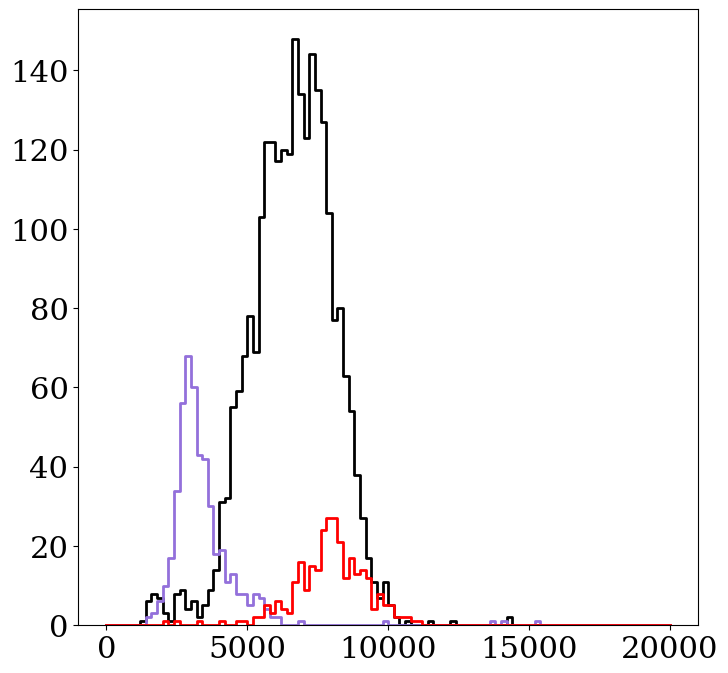

In [108]:
# half width dists before 
fig,ax = plt.subplots(figsize=(8,8))
S2_width_axis =  hist.axis.Regular(100,0,20000,name="S2_width", label="S2 Width",flow=False)

S2_width_trit_hist = Hist(S2_width_axis)
S2_width_trit_hist.fill(width_test[trit_cut2])

S2_width_cath_hist = Hist(S2_width_axis)
S2_width_cath_hist.fill(width_test[cath_cut2])

S2_width_gate_hist = Hist(S2_width_axis)
S2_width_gate_hist.fill(width_test[gate_cut2])

S2_width_trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
S2_width_gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
S2_width_cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)




[StepArtists(step=<matplotlib.lines.Line2D object at 0x000001DE1D20FA30>, errorbar=None, legend_artist=None)]

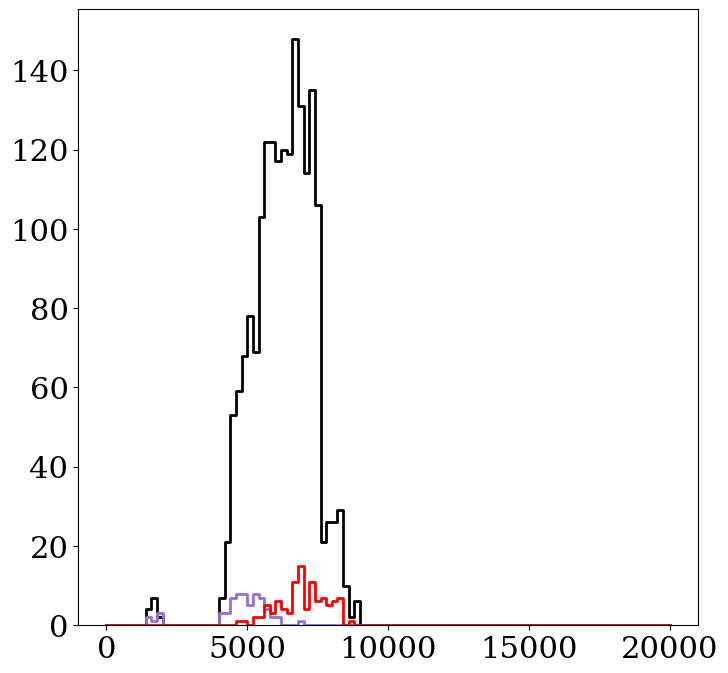

In [109]:
# & after
trit_cut_data = pd.DataFrame(trit_cut_data)
gate_cut_data = pd.DataFrame(gate_cut_data)
cath_cut_data = pd.DataFrame(cath_cut_data)

fig,ax = plt.subplots(figsize=(8,8))

S2_width_trit_hist = Hist(S2_width_axis)
S2_width_trit_hist.fill(trit_cut_data['data'])

S2_width_cath_hist = Hist(S2_width_axis)
S2_width_cath_hist.fill(cath_cut_data['data'])

S2_width_gate_hist = Hist(S2_width_axis)
S2_width_gate_hist.fill(gate_cut_data['data'])

S2_width_trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)
S2_width_gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
S2_width_cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)

#TODO

- Histogram with gas events :)
- BDT without gas events 
    - Same ROC curves for this BDT as before :)
- Histograms of params against S2 size
    - Split into classes :)
- 1D histogram of y score for each bin, sep into gate, cath, trit
    - plot line to keep 80% of trit events (disc_score_cut)
    - apply cut & normalise with total events to get data point
    - width from width of bin
    - yerror from poisson error - sqrt(num)/denom
- Make for width only BDT also
- Make combined ROC curves of BDTs
- Optimise hyperparams 
- Clean up notebook & make final plots 


# Notes 
- Importances didn't make sense visually from dtxx_xx scatter plots so ran BDTs with only gate and only cathode
    - Cathode heavily favouring the dt50_25 which explains the skew 
- Ran with max_depth set to 1 which fixed the test error? Also made the importances a bit more even 